In [1]:

import os
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import copy
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [2]:

# 配置信息
class Cfg:
    data_root = os.path.abspath(os.path.join(os.getcwd(), "../exp-2/data")) 
    train_fraction = 0.10          # use 10% of the train split
    test_fraction  = 0.10          # use 10% of the test split
    train_num_pairs = 10000        # number of training pairs
    test_num_pairs  = 2000         # number of test pairs
    batch_size = 64
    num_workers = 2
    save_dir = os.path.abspath(os.path.join(os.getcwd(), "../exp-2/output"))
    model_name = 'siamese_mnist_same_digit.pth'

os.makedirs(Cfg.save_dir, exist_ok=True)
Cfg.__dict__


mappingproxy({'__module__': '__main__',
              'data_root': '/home/xingzhuang/workplace/wjl/CV/exp-2/data',
              'train_fraction': 0.1,
              'test_fraction': 0.1,
              'train_num_pairs': 10000,
              'test_num_pairs': 2000,
              'batch_size': 64,
              'num_workers': 2,
              'save_dir': '/home/xingzhuang/workplace/wjl/CV/exp-2/output',
              'model_name': 'siamese_mnist_same_digit.pth',
              '__dict__': <attribute '__dict__' of 'Cfg' objects>,
              '__weakref__': <attribute '__weakref__' of 'Cfg' objects>,
              '__doc__': None})

In [3]:

# Transforms预处理
transform = transforms.Compose([
    transforms.ToTensor(), # 归一化[0,1], shape (1,28,28)
    transforms.Normalize((0.1307,), (0.3081,)),
])

# 加载MNIST数据集
train_dataset = datasets.MNIST(Cfg.data_root, train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST(Cfg.data_root, train=False, download=True, transform=transform)

# 抽取10%的数据
def sample_dataset(dataset, sample_ratio=0.1):
    indices = list(range(len(dataset)))
    sampled_indices = random.sample(indices, int(len(dataset) * sample_ratio))
    return Subset(dataset, sampled_indices)
train_subset = sample_dataset(train_dataset, Cfg.train_fraction)
test_subset = sample_dataset(test_dataset, Cfg.test_fraction)

# 创建配对数据集
class MNISTPairsDataset(Dataset):
    def __init__(self, subset, num_pairs):
        self.subset = subset
        self.num_pairs = num_pairs
        self.labels = [label for _, label in subset]
        self.images = [image for image, _ in subset]
        # 生成相同数字的索引映射
        label_to_indices = {}
        for idx, label in enumerate(self.labels):
            if label not in label_to_indices:
                label_to_indices[label] = []
            label_to_indices[label].append(idx)
        # 创建配对
        self.pairs = []
        self.pair_labels = []
        for _ in range(num_pairs // 2):
            # 正样本对
            label = random.choice(list(label_to_indices.keys()))
            if len(label_to_indices[label]) >= 2:
                idx1, idx2 = random.sample(label_to_indices[label], 2)
                self.pairs.append((idx1, idx2))
                self.pair_labels.append(1)
            # 负样本对
            label1, label2 = random.sample(list(label_to_indices.keys()), 2)
            idx1 = random.choice(label_to_indices[label1])
            idx2 = random.choice(label_to_indices[label2])
            self.pairs.append((idx1, idx2))
            self.pair_labels.append(0)
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        idx1, idx2 = self.pairs[idx]
        x1 = self.images[idx1]
        x2 = self.images[idx2]
        y = self.pair_labels[idx]
        return x1, x2, torch.tensor(y, dtype=torch.float32)

# 创建训练和测试配对数据集
train_pairs_dataset = MNISTPairsDataset(train_subset, num_pairs=Cfg.train_num_pairs)
test_pairs_dataset = MNISTPairsDataset(test_subset, num_pairs=Cfg.test_num_pairs)

# 数据加载器
train_loader = DataLoader(train_pairs_dataset, batch_size=Cfg.batch_size, shuffle=True, num_workers=Cfg.num_workers)
test_loader = DataLoader(test_pairs_dataset, batch_size=Cfg.batch_size, shuffle=False, num_workers=Cfg.num_workers)

len(train_dataset), len(test_dataset), len(train_subset), len(test_subset), len(train_loader), len(test_loader)


(60000, 10000, 6000, 1000, 157, 32)

In [4]:

class ConvEncoder(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   # 1x28x28 -> 16x28x28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # -> 16x14x14
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # -> 32x14x14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # -> 32x7x7
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, emb_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x

class SiameseSameDigit(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()
        self.encoder = ConvEncoder(emb_dim=emb_dim)
        # 使用绝对差和元素级乘积组合特征
        self.head = nn.Sequential(
            nn.Linear(emb_dim*2, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1),  # logit
            nn.Sigmoid()  # 输出概率
        )

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        feat = torch.cat([torch.abs(z1 - z2), z1 * z2], dim=1)
        logit = self.head(feat)
        return logit.squeeze(1)  # (B,)

model = torch.load(os.path.join(Cfg.save_dir, Cfg.model_name), map_location=device, weights_only=False)
model = model.to(device)
print("模型已从指定路径加载")


模型已从指定路径加载


In [5]:

@torch.no_grad()
def get_avg_feature_maps_over_test(model, test_loader):
    """计算测试集上最后一层卷积层的平均特征图和每个通道的平均激活分数"""
    model.eval()
    acts_sum = None
    n_imgs = 0

    def hook(module, inp, out):
        nonlocal acts_sum, n_imgs
        # out: [N, C, H, W]
        o = out.detach().to("cpu")
        batch_sum = o.sum(dim=0)     # [C, H, W]
        acts_sum = batch_sum if acts_sum is None else (acts_sum + batch_sum)
        n_imgs += o.shape[0]

    conv = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            conv = m
    assert conv is not None
    print("最后一层卷积层结构:", conv)

    handle = conv.register_forward_hook(hook)
    # 跑一遍测试集，正常前向（Siamese 会对 x1/x2 两次触发 hook）
    for x1, x2, y in test_loader:
        x1, x2 = x1.to(device), x2.to(device)
        _ = model(x1, x2)   # 只为触发 hook
    handle.remove()

    avg_maps = acts_sum / float(n_imgs)         # [C, H, W]
    print("最后一层卷积层输出图像shape:", avg_maps.shape)
    # 每个通道的标量“平均激活”用于排序
    channel_scores = avg_maps.mean(dim=(1,2))   # [C]
    return avg_maps, channel_scores

avg_maps, channel_scores = get_avg_feature_maps_over_test(model, test_loader)


最后一层卷积层结构: Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
最后一层卷积层输出图像shape: torch.Size([32, 14, 14])


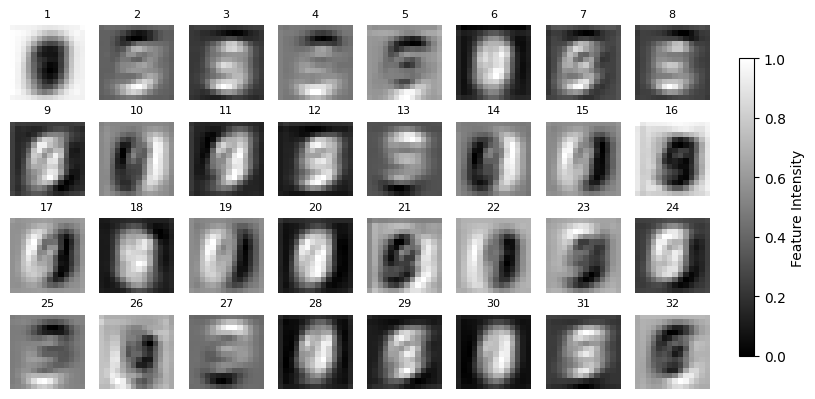

In [6]:

def plot_avg_feature_maps(avg_maps, cols=8):
    """可视化平均特征图"""
    C, H, W = avg_maps.shape

    # 归一化到[0,1]
    def norm01(x):
        x = x - x.min()
        den = x.max() + 1e-8
        return (x / den)

    rows = int(np.ceil(C / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.2, rows * 1.2))
    
    for i in range(C):
        ax = axes[i // cols, i % cols]
        im = ax.imshow(norm01(avg_maps[i].numpy()), cmap='gray')
        ax.axis('off')
        ax.set_title(str(i + 1), fontsize=8)

    cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Feature Intensity', fontsize=10)
    plt.show()

plot_avg_feature_maps(avg_maps, cols=8)


In [7]:

def prune_last_conv_by_K(model, channel_scores, K):
    """返回一个剪枝后的模型拷贝，不改原模型"""
    pruned = copy.deepcopy(model)
    
    conv = None
    for m in pruned.modules():
        if isinstance(m, nn.Conv2d):
            conv = m 
    assert conv is not None

    # 从低到高选出要置零的通道索引
    idx_sorted = torch.argsort(channel_scores)     # [C] 升序
    idx_prune = idx_sorted[:K].tolist() if K>0 else []

    with torch.no_grad():
        if len(idx_prune) > 0:
            conv.weight[idx_prune, ...] = 0.0
            if conv.bias is not None:
                conv.bias[idx_prune] = 0.0
    return pruned

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_correct = 0
    total = 0
    for x1, x2, y in loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        outputs = model(x1, x2)
        preds = (outputs >= 0.5).float()
        total_correct += (preds == y.view_as(preds)).sum().item()
        total += y.size(0)
    return total_correct/total

K_list = list(range(1,32))
acc_list = []
for K in K_list:
    pruned_model = prune_last_conv_by_K(model, channel_scores, K)
    acc = evaluate(pruned_model, test_loader)
    acc_list.append(acc)
    print(f"K={K:2d} | Test Acc={acc:.4f}")


K= 1 | Test Acc=0.9620
K= 2 | Test Acc=0.9625
K= 3 | Test Acc=0.9520
K= 4 | Test Acc=0.9450
K= 5 | Test Acc=0.9345
K= 6 | Test Acc=0.9320
K= 7 | Test Acc=0.9310
K= 8 | Test Acc=0.9305
K= 9 | Test Acc=0.9340
K=10 | Test Acc=0.9370
K=11 | Test Acc=0.9365
K=12 | Test Acc=0.9385
K=13 | Test Acc=0.9315
K=14 | Test Acc=0.9280
K=15 | Test Acc=0.9280
K=16 | Test Acc=0.9325
K=17 | Test Acc=0.9175
K=18 | Test Acc=0.9175
K=19 | Test Acc=0.9200
K=20 | Test Acc=0.9245
K=21 | Test Acc=0.9235
K=22 | Test Acc=0.9215
K=23 | Test Acc=0.9115
K=24 | Test Acc=0.8770
K=25 | Test Acc=0.8895
K=26 | Test Acc=0.8055
K=27 | Test Acc=0.7810
K=28 | Test Acc=0.7870
K=29 | Test Acc=0.5970
K=30 | Test Acc=0.6155
K=31 | Test Acc=0.5345


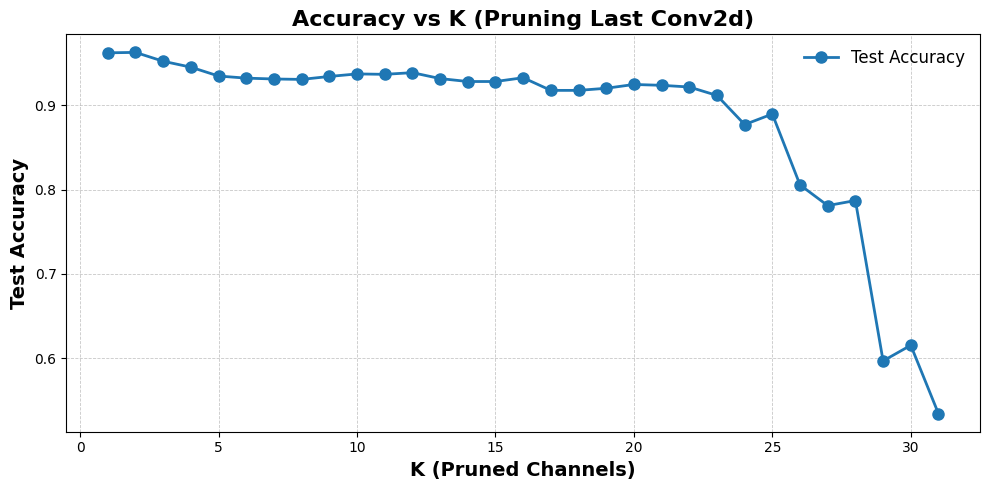

In [8]:

def pltot_accuracy_vs_K(x, y):
    """绘制 K vs Accuracy 曲线"""
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, color='#1f77b4', marker='o', markersize=8, linewidth=2, label='Test Accuracy')
    plt.xlabel("K (Pruned Channels)", fontsize=14, fontweight='bold')
    plt.ylabel("Test Accuracy", fontsize=14, fontweight='bold')
    plt.title("Accuracy vs K (Pruning Last Conv2d)", fontsize=16, fontweight='bold')
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    plt.legend(fontsize=12, loc='best', frameon=False)
    plt.tight_layout()
    plt.show()

pltot_accuracy_vs_K(K_list, acc_list)
